In [66]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [90]:
import yfinance as yf

data = yf.download("BTC-USD", interval="1wk")[["Close"]].dropna()
data.columns = ["BTC"]
data.head()

[*********************100%***********************]  1 of 1 completed


,BTC
Date,
2014-09-15,398.821014
2014-09-22,377.181000
2014-09-29,320.510010
2014-10-06,378.549011
2014-10-13,389.545990


In [91]:
data = data.drop(data.index[-1])

data.tail()

,BTC
Date,
2024-06-03,69647.992188
2024-06-10,66639.046875
2024-06-17,63180.796875
2024-06-24,62678.292969
2024-07-01,58303.539062


In [92]:
data_path = Path('data')
if not data_path.exists():
    data_path.mkdir(parents=True)

In [93]:

data_path = (data_path / 'btc_data.csv').as_posix()
data.to_csv(data_path)

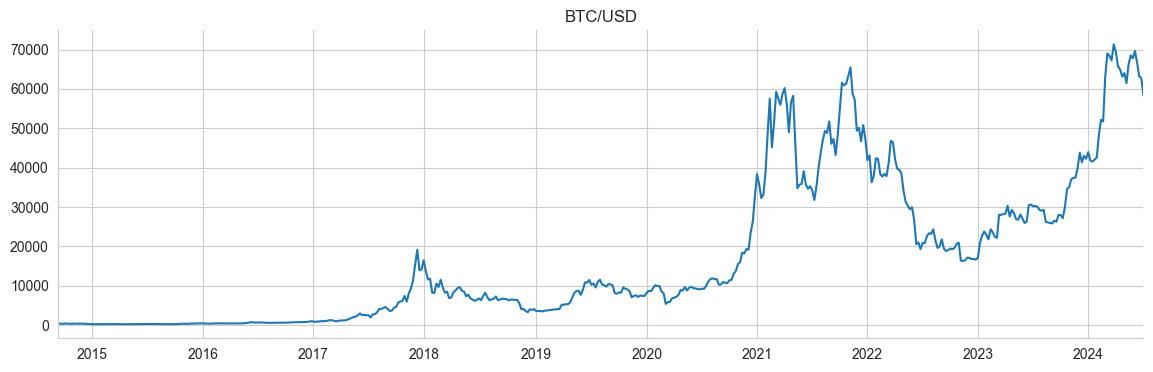

In [9]:
ax = data.plot(title='BTC/USD',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

### Preprocessing

In [10]:
scaler = MinMaxScaler()

In [67]:
# Save the scaler object into binary file
rnn_path = (results_path / 'scaler.pkl').as_posix()
with open(rnn_path, 'wb') as file:
    pickle.dump(scaler, file)

In [11]:
data_scaled = pd.Series(scaler.fit_transform(data).squeeze(),
                         index=data.index)
data_scaled.describe()

count    512.000000
mean       0.235925
std        0.265592
min        0.000000
25%        0.011737
50%        0.120721
75%        0.390801
max        1.000000
dtype: float64

In [12]:
data_scaled.shape

(512,)

For window size $S$, the relationship takes the form

$ x_t = f(x_{t-1}, x_{t-2}, \ldots, x_{t-S}) \quad \forall t = S, S+1, \ldots, T $

Each of the $T - S$ lagged input sequence or vector is of length $S$ with a corresponding scalar output.



In [13]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [14]:
window_size = 20
X, y = create_univariate_rnn_data(data_scaled, window_size=window_size)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2015-02-02,0.002650,0.002346,0.001549,0.002365,0.002520,0.002030,0.001625,0.002150,0.002496,0.002211,0.002358,0.002316,0.001987,0.001554,0.001503,0.000757,0.000778,0.000000,0.000610,0.000234
2015-02-09,0.002346,0.001549,0.002365,0.002520,0.002030,0.001625,0.002150,0.002496,0.002211,0.002358,0.002316,0.001987,0.001554,0.001503,0.000757,0.000778,0.000000,0.000610,0.000234,0.000184
2015-02-16,0.001549,0.002365,0.002520,0.002030,0.001625,0.002150,0.002496,0.002211,0.002358,0.002316,0.001987,0.001554,0.001503,0.000757,0.000778,0.000000,0.000610,0.000234,0.000184,0.000344
2015-02-23,0.002365,0.002520,0.002030,0.001625,0.002150,0.002496,0.002211,0.002358,0.002316,0.001987,0.001554,0.001503,0.000757,0.000778,0.000000,0.000610,0.000234,0.000184,0.000344,0.000360
2015-03-02,0.002520,0.002030,0.001625,0.002150,0.002496,0.002211,0.002358,0.002316,0.001987,0.001554,0.001503,0.000757,0.000778,0.000000,0.000610,0.000234,0.000184,0.000344,0.000360,0.000701


In [15]:
y.head()

Date
2015-02-02    0.000184
2015-02-09    0.000344
2015-02-16    0.000360
2015-02-23    0.000701
2015-03-02    0.000900
dtype: float64

### Train-test split

In [16]:
# Percentage train set
split = int(0.80*len(X))
X_train, X_test = X[:split].values.reshape(-1, window_size, 1), X[split:].values.reshape(-1, window_size, 1)
y_train, y_test = y[:split], y[split:]

In [17]:
n_obs, window_size, n_features = X_train.shape

In [18]:
print(f'n_obs: {n_obs}')
print(f'window_size: {window_size}')
print(f'n_features: {n_features}')

n_obs: 393
window_size: 20
n_features: 1


### Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN. We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the `mean_squared_error` loss should be used (remember: we are performing regression here)


In [22]:
rnn = Sequential([
    LSTM(units=15,
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [23]:
rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 15)                1020      
                                                                 
 Output (Dense)              (None, 1)                 16        
                                                                 
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


### Train the Model

We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:


In [24]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08)

In [25]:
rnn.compile(loss='mean_squared_error',
            optimizer=optimizer)

We define an EarlyStopping callback and train the model for up to 100 episodes.

In [26]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [27]:
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=20,
                              restore_best_weights=True)

In [28]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150
19/20 [===========================>..] - ETA: 0s - loss: 0.0489
Epoch 1: val_loss improved from inf to 0.07154, saving model to results/univariate_time_series\rnn.h5
20/20 [==============================] - 12s 117ms/step - loss: 0.0479 - val_loss: 0.0715
Epoch 2/150
18/20 [==========================>...] - ETA: 0s - loss: 0.0159
Epoch 2: val_loss improved from 0.07154 to 0.02184, saving model to results/univariate_time_series\rnn.h5
20/20 [==============================] - 1s 26ms/step - loss: 0.0151 - val_loss: 0.0218
Epoch 3/150
17/20 [========================>.....] - ETA: 0s - loss: 0.0066
Epoch 3: val_loss improved from 0.02184 to 0.01022, saving model to results/univariate_time_series\rnn.h5
20/20 [==============================] - 0s 22ms/step - loss: 0.0070 - val_loss: 0.0102
Epoch 4/150
16/20 [=======================>......] - ETA: 0s - loss: 0.0058
Epoch 4: val_loss did not improve from 0.01022
20/20 [==============================] - 0s 18ms/step - loss: 0.0059 

### Evaluate model performance

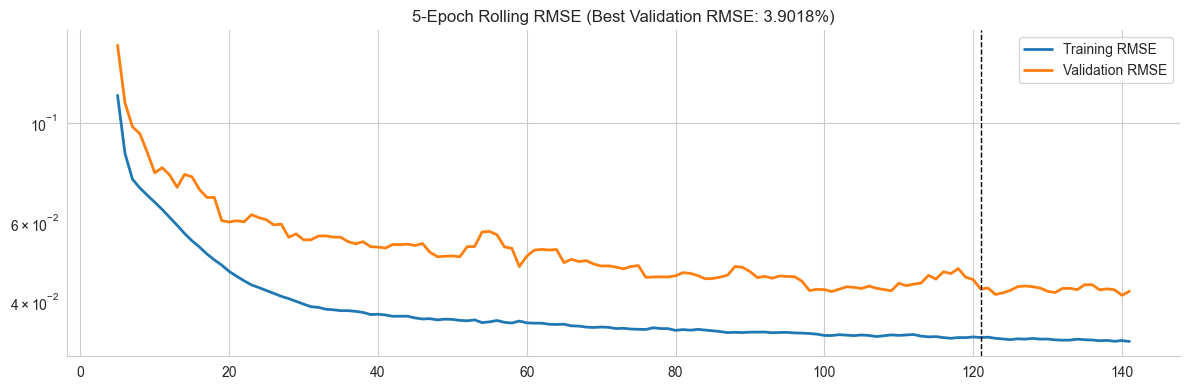

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_bitcoin_error', dpi=300);

In [30]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0326 | Test RMSE: 0.0390


In [31]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

4/4 [==============================] - 0s 6ms/step


The Test Information Coefficient (IC) is a statistical measure primarily used in the context of quantitative finance and investing to evaluate the effectiveness of a prediction model. The IC measures the correlation between a model's predictions and the actual observed outcomes, providing an indication of how well the model is performing.

### Characteristics of IC

1. **Correlation**: The IC is calculated as the Pearson correlation between the predictions and the actual values. If the predictions and observed outcomes are perfectly correlated (positively or negatively), the IC will be +1 or -1, respectively.
2. **IC Sign**:
   - A positive IC indicates that the model's predictions are well aligned with the actual outcomes.
   - A negative IC suggests that the model's predictions are inversely related to the actual outcomes.
   - An IC close to zero indicates little to no correlation between the predictions and the actual outcomes.
3. **Use in Finance**: In the context of investing, a high IC indicates that the model may be useful for making investment decisions. For example, if the model correctly predicts asset returns, it can be used to construct a more efficient investment portfolio.

### IC Calculation

The IC is calculated using the Pearson correlation formula:

$ \text{IC} = \frac{\sum (P_i - \bar{P})(R_i - \bar{R})}{\sqrt{\sum (P_i - \bar{P})^2} \sqrt{\sum (R_i - \bar{R})^2}}$

where:
- $ P_i $ are the model's predictions.
- $ R_i $ are the actual observed outcomes.
- $ \bar{P} $ is the mean of the predictions.
- $ \bar{R} $ is the mean of the actual outcomes.

### Application Example

Suppose you have a model that predicts future returns of a series of stocks. After a test period, you can calculate the IC to determine how well the model's predictions matched the actual returns of the stocks. A high IC would indicate that the model is effective and could be useful for investment strategies.

### Importance of IC

The IC is an important tool for fund managers and quantitative analysts because it allows for an objective assessment of the quality of prediction models. A consistently high and positive IC is a signal that the model has the potential to generate alpha (returns above the market average).

In summary, the Test Information Coefficient (IC) is a key metric for evaluating the accuracy and usefulness of predictive models in finance, helping investors make informed decisions based on the correlation between predictions and actual outcomes.


In [32]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9918 | Test IC: 0.9682


### Rescale predictions

In [33]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(),
                          index=y_test.index))

In [34]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [35]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 2315.82 | Test RMSE: 2775.05'

In [36]:
data['Train Predictions'] = train_predict
data['Test Predictions'] = test_predict

train_df = train_predict.to_frame('predictions').assign(data='Train')
test_df = test_predict.to_frame('predictions').assign(data='Test')

combined_df = pd.concat([train_df, test_df])

data_copy = data.join(combined_df)

### Plot Results

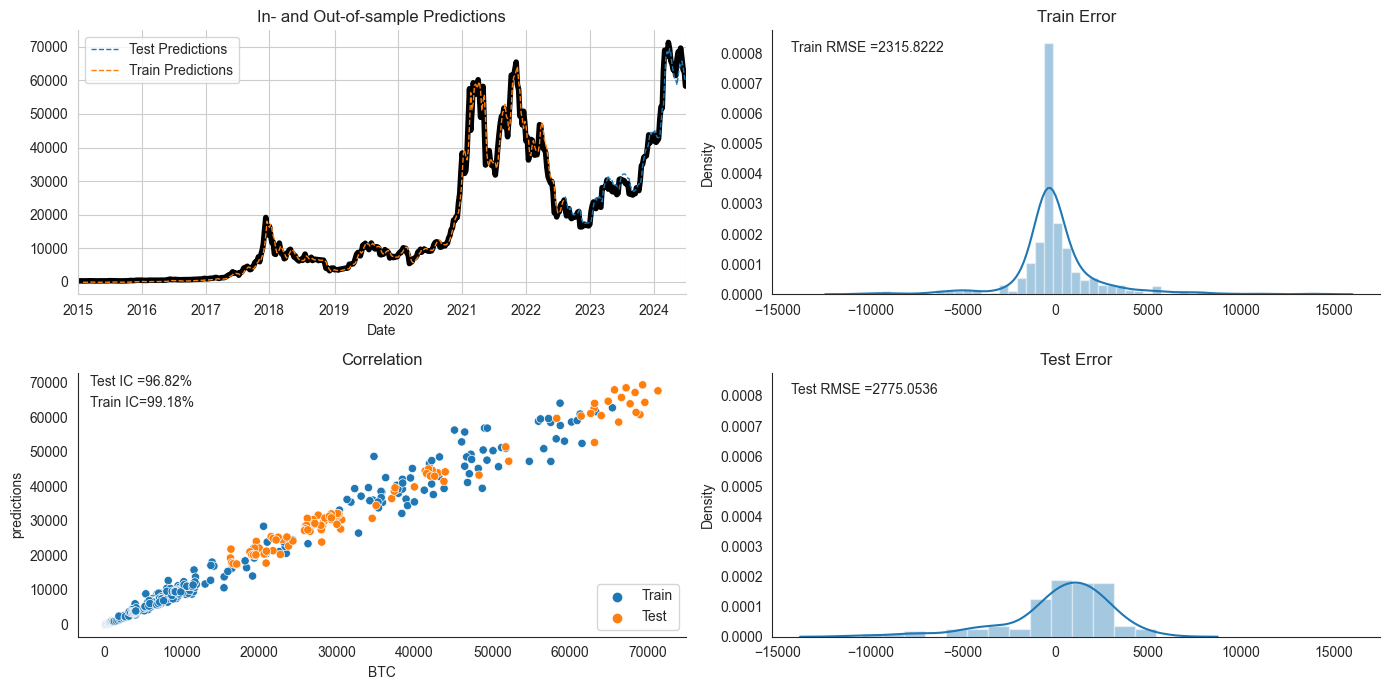

In [37]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

data_copy.loc['2015':, 'BTC'].plot(lw=4, ax=ax1, c='k')
data_copy.loc['2015':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='BTC', y='predictions', data = data_copy, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')

    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_bitcoin_regression', dpi=300)

In [38]:
data_copy

,BTC,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2014-09-15,398.821014,NaN,NaN,NaN,NaN
2014-09-22,377.181000,NaN,NaN,NaN,NaN
2014-09-29,320.510010,NaN,NaN,NaN,NaN
2014-10-06,378.549011,NaN,NaN,NaN,NaN
2014-10-13,389.545990,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-06-03,69647.992188,NaN,64371.121094,64371.121094,Test
2024-06-10,66639.046875,NaN,65777.507812,65777.507812,Test
2024-06-17,63180.796875,NaN,64079.128906,64079.128906,Test


### Forecast for July 15th

In [53]:
data_test = yf.download("BTC-USD", interval="1wk")[["Close"]].dropna()

[*********************100%***********************]  1 of 1 completed


In [99]:
data_path = ('data/btc_data.csv')
data_test = pd.read_csv(data_path, index_col = 'Date')

In [100]:
data_test.head()

,BTC
Date,
2014-09-15,398.821014
2014-09-22,377.181000
2014-09-29,320.510010
2014-10-06,378.549011
2014-10-13,389.545990


In [101]:
data_test.tail()

,BTC
Date,
2024-06-03,69647.992188
2024-06-10,66639.046875
2024-06-17,63180.796875
2024-06-24,62678.292969
2024-07-01,58303.539062


In [102]:
import pickle

# Load the scaler object from binary file
scaler_path = (results_path / 'scaler.pkl').as_posix()
with open(scaler_path, 'rb') as file:
    scaler = pickle.load(file)


In [103]:
data_test_scaled = pd.Series(scaler.fit_transform(data_test).squeeze(),
                         index=data_test.index)

In [104]:
window_size = 20
X_test, _ = create_univariate_rnn_data(data_test_scaled, window_size=window_size)
X_test.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2024-06-03,0.581180,0.588067,0.595772,0.676059,0.729890,0.724417,0.885181,0.967467,0.958621,0.942361,1.000000,0.972286,0.921335,0.909917,0.884420,0.897326,0.861012,0.928922,0.960413,0.949636
2024-06-10,0.588067,0.595772,0.676059,0.729890,0.724417,0.885181,0.967467,0.958621,0.942361,1.000000,0.972286,0.921335,0.909917,0.884420,0.897326,0.861012,0.928922,0.960413,0.949636,0.976300
2024-06-17,0.595772,0.676059,0.729890,0.724417,0.885181,0.967467,0.958621,0.942361,1.000000,0.972286,0.921335,0.909917,0.884420,0.897326,0.861012,0.928922,0.960413,0.949636,0.976300,0.933993
2024-06-24,0.676059,0.729890,0.724417,0.885181,0.967467,0.958621,0.942361,1.000000,0.972286,0.921335,0.909917,0.884420,0.897326,0.861012,0.928922,0.960413,0.949636,0.976300,0.933993,0.885370
2024-07-01,0.729890,0.724417,0.885181,0.967467,0.958621,0.942361,1.000000,0.972286,0.921335,0.909917,0.884420,0.897326,0.861012,0.928922,0.960413,0.949636,0.976300,0.933993,0.885370,0.878305


In [105]:
X_test = X_test.tail(1)

In [106]:
X_test.shape

(1, 20)

In [107]:
from tensorflow.keras.models import load_model

# Load de net model from HDF5 file
rnn_path = (results_path / 'rnn.h5').as_posix()
rnn_loaded = load_model(rnn_path)


In [108]:
data_predict_scaled = rnn_loaded.predict(X_test)
data_predict_scaled

1/1 [==============================] - 1s 1s/step


array([[0.8367514]], dtype=float32)

In [109]:
data_predict = pd.Series(scaler.inverse_transform(data_predict_scaled).squeeze(), index=X_test.index)

In [110]:
print(f'Forecast for July 15th: {data_predict}')

Forecast for July 15th: Date
2024-07-01    59722.871094
dtype: float32


In [115]:
last_data = int(data_test.tail(1).values)


In [119]:
ROI = (data_predict - last_data )/last_data * 100
print(f'ROI: {ROI}')

ROI: Date
2024-07-01    2.435331
dtype: float32
